In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import requests
from scipy import stats

### Current Listing Data

In [302]:
curr_df = pd.read_csv('./update_df.csv')

In [303]:
curr_df[:3]

,property_id,prop_type,prop_sub_type,prop_status,price,baths_full,baths,beds,last_update,photo_count,...,state_code,county,lat,lon,neighborhood_name,buiding_size(sqft),lot_size(sqft),agent_id,agent_name,brand_name
0,M4046594895,condo,duplex_triplex,for_sale,249900,3.0,3,6.0,2020-10-13T17:54:05Z,9,...,PA,Philadelphia,39.974408,-75.243700,West Philadelphia,1632.0,1842.0,1291281.0,Ausra Anusauskas,Archstone Realty
1,M3939384476,condo,townhomes,for_sale,116800,1.0,1,3.0,2020-10-13T18:18:18Z,7,...,PA,Philadelphia,39.926283,-75.225382,Southwest Philadelphia,1092.0,992.0,347285.0,Dr Hanh Vo,Vihi Realty
2,M4036371277,condo,townhomes,for_sale,215000,1.0,2,3.0,2020-10-13T17:24:20Z,35,...,PA,Philadelphia,40.039721,-75.142100,Upper North District,1360.0,1501.0,NaN,Kevin Chen,Premium Realty Castor Inc


In [304]:
curr_df.rename(columns = {'postal_code':'zip_code'}, inplace=True)

### Historical Listing Data

In [305]:
hist_df = pd.read_csv('./hist_price_with_zip.csv')

In [306]:
hist_df.head()

,property_id,event_name,date,price,price_range_min,price_range_max,price_changed,sqft,datasource_name,source,listing,iso_date,listing_id,previous_event_price,postal_code
0,M3392201642,Price Changed,2020-10-17T17:00:00Z,355000,NaN,NaN,5000,1750,BrightMLS,MLS #PAPH935838,NaN,NaN,NaN,NaN,19116
1,M3392201642,Listed,2020-10-11T17:00:00Z,350000,NaN,NaN,0,1750,BrightMLS,MLS #PAPH935838,NaN,NaN,NaN,NaN,19116
2,M3164904583,Listed,2020-10-11T17:00:00Z,149900,NaN,NaN,0,1176,BrightMLS,MLS #PAPH944164,NaN,NaN,NaN,NaN,19143
3,M3164904583,Sold,2002-03-18T17:00:00Z,70500,NaN,NaN,0,1176,NaN,Public Record,NaN,NaN,NaN,NaN,19143
4,M3164904583,Sold,1988-09-21T17:00:00Z,33900,NaN,NaN,0,1176,NaN,Public Record,NaN,NaN,NaN,NaN,19143


In [307]:
# Remove 'T00:00:00Z' from 'date'
hist_df['date'] =  [re.sub('T(.*?)Z','', str(x)) for x in hist_df['date']]

In [308]:
# Covnert 'date' to a datetime object
hist_df['date'] = pd.to_datetime(hist_df['date'])

In [309]:
hist_df.rename(columns = {'postal_code':'zip_code'}, inplace=True)

### Subset properties listed from January 2019 - February 2020

In [310]:
# Subset July 2019 - February 2020
hist_19 = hist_df[hist_df['date'].isin(pd.date_range(start='2019-01-01', end='2020-02-29'))]

In [316]:
print('length of full hist_df =', len(hist_df))
print('length of df subset for January 2019 - February 2020 =', len(hist_19))
print('So we lose %d instsances after subsetting' % (len(hist_df) - len(hist_19)))

length of full hist_df = 60459
length of df subset for January 2019 - February 2020 = 5728
So we lose 54731 instsances after subsetting


### Drop the extra listing data, keep the last listing.

In [132]:
final_hist = hist_19.sort_values('date').drop_duplicates('property_id',keep='last')

In [323]:
print('After keeping only the last listed piece of data for each property')
print('in our final historical dataset, we are left with', len(final_hist['zip_code']), 'instances.')
print('The dataset for the current listings has', len(curr_df), 'instances.')

After keeping only the last listed piece of data for each property
in our final historical dataset, we are left with 2493 instances.
The dataset for the current listings has 9562 instances.


### Test outcomes by zip

In [324]:
# Tests by zip
url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM covid_cases_by_zip'
response = requests.request("GET", url)
test_zip = pd.json_normalize(response.json()['rows'])

In [325]:
test_zip.head()

,cartodb_id,the_geom,the_geom_webmercator,covid_status,zip_code,count,etl_timestamp
0,1,None,None,NEG,19113,46,2020-11-12T18:20:02Z
1,2,None,None,POS,19154,1051,2020-11-12T18:20:02Z
2,3,None,None,POS,19132,1111,2020-11-12T18:20:02Z
3,4,None,None,NEG,19104,25455,2020-11-12T18:20:02Z
4,5,None,None,NEG,19101,221,2020-11-12T18:20:02Z


In [326]:
# Subset for positive tests
pos_zip = test_zip[test_zip['covid_status'] == 'POS']

In [327]:
# Top 5 zips by count
top_5_zips = []

for i in pos_zip.sort_values('count', ascending=False)[:4]['zip_code']:
    top_5_zips.append(i)
    
top_5_zips

['19120', '19124', '19111', '19140']

In [328]:
# Bottom 5 zips by count
bottom_5_zips = []

for i in pos_zip.sort_values('count', ascending=False)[-4:]['zip_code']:
    bottom_5_zips.append(i)
    
bottom_5_zips

['19102', '19127', '19101', '19105']

In [73]:
# pos_zip['zip_code'] = pos_zip['zip_code'].astype(int)

### Subset the zips with the top 5 most positive case counts and the bottom 5 least positive case counts

In [329]:
top5_hist = hist_19[hist_19['zip_code'].isin(top_5_zips)]
bot5_hist = hist_19[hist_19['zip_code'].isin(bottom_5_zips)]

In [330]:
top5_curr = curr_df[curr_df['zip_code'].isin(top_5_zips)]
bot5_curr = curr_df[curr_df['zip_code'].isin(bottom_5_zips)]

# Statistical Analysis

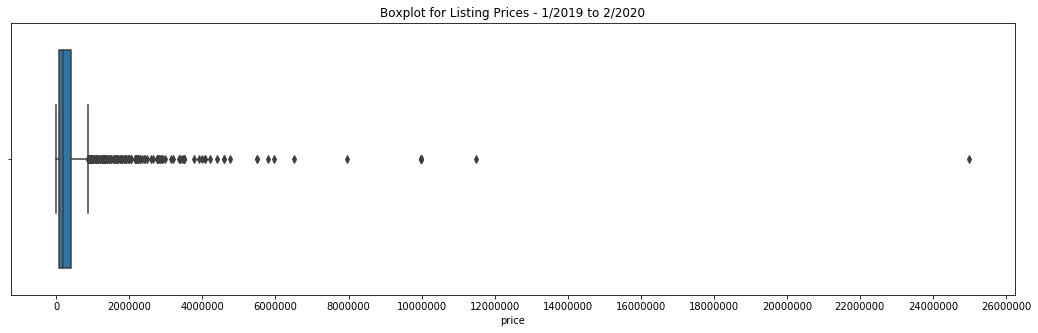

In [374]:
plt.subplots(figsize=(18,5))
hist_prices_plot = sns.boxplot(final_hist['price'])
hist_prices_plot.set(xticks=np.arange(0, 26000001, 2000000))
hist_prices_plot.set_title('Boxplot for Listing Prices - 1/2019 to 2/2020')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

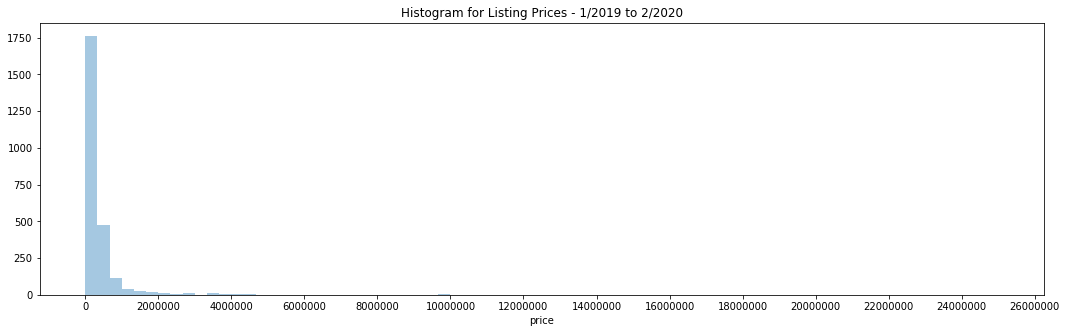

In [380]:
plt.subplots(figsize=(18,5))
hist_prices_histo = sns.distplot(final_hist['price'], kde=False, bins=75)
hist_prices_histo.set_title('Histogram for Listing Prices - 1/2019 to 2/2020')
hist_prices_histo.set(xticks=np.arange(0, 26000001, 2000000))
plt.ticklabel_format(style='plain', axis='x')
plt.show()

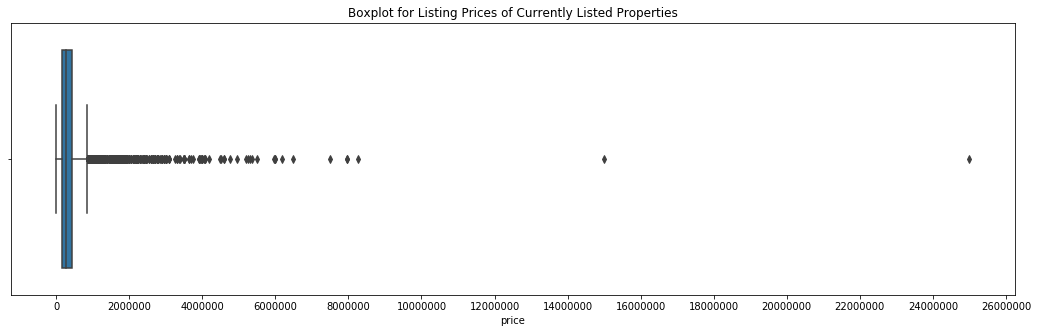

In [376]:
plt.subplots(figsize=(18,5))
curr_prices_plot = sns.boxplot(curr_df['price'])
curr_prices_plot.set(xticks=np.arange(0, 26000001, 2000000))
curr_prices_plot.set_title('Boxplot for Listing Prices of Currently Listed Properties')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

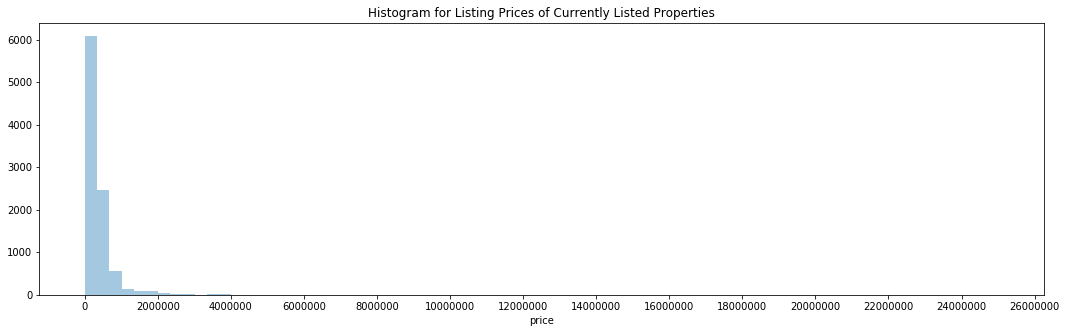

In [379]:
plt.subplots(figsize=(18,5))
curr_prices_histo = sns.distplot(curr_df['price'], kde=False, bins=75)
curr_prices_histo.set_title('Histogram for Listing Prices of Currently Listed Properties')
curr_prices_histo.set(xticks=np.arange(0, 26000001, 2000000))
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [365]:
print('Descriptive statistics for the full historical dataset.')
stats.describe(final_hist['price'])

Descriptive statistics for the full historical dataset.


DescribeResult(nobs=2493, minmax=(900, 25000000), mean=381891.5286803049, variance=854534661057.5542, skewness=12.2668021425143, kurtosis=241.80308075608949)

In [366]:
print('Descriptive statistics for the full current dataset.')
stats.describe(curr_df['price'])

Descriptive statistics for the full current dataset.


DescribeResult(nobs=9562, minmax=(6000, 25000000), mean=381703.5611796695, variance=313156718177.5901, skewness=14.452907462413856, kurtosis=469.3509268783856)

### Remove outliers in both datasets
* We'll choose to get rid of listings greater than $900,000.

In [339]:
final_hist2 = final_hist[final_hist['price'] < 900000]

In [340]:
curr_df2 = curr_df[curr_df['price'] < 900000]

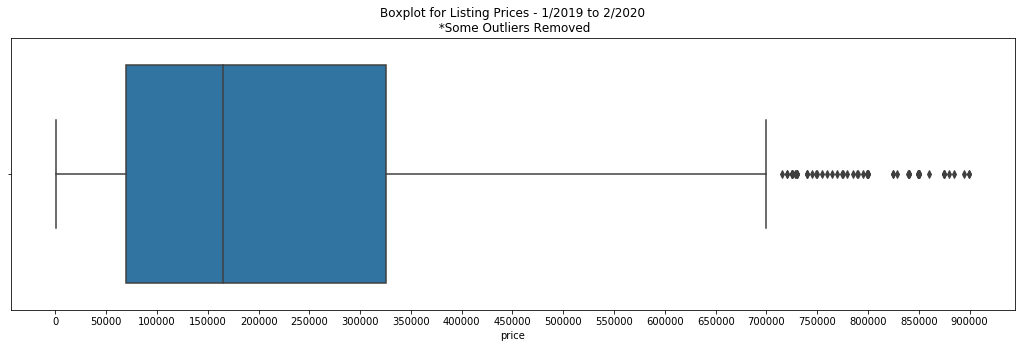

In [381]:
plt.subplots(figsize=(18,5))
hist_prices_plot = sns.boxplot(final_hist2['price'])
hist_prices_plot.set(xticks=np.arange(0, 900001, 50000))
hist_prices_plot.set_title('Boxplot for Listing Prices - 1/2019 to 2/2020\n *Some Outliers Removed')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

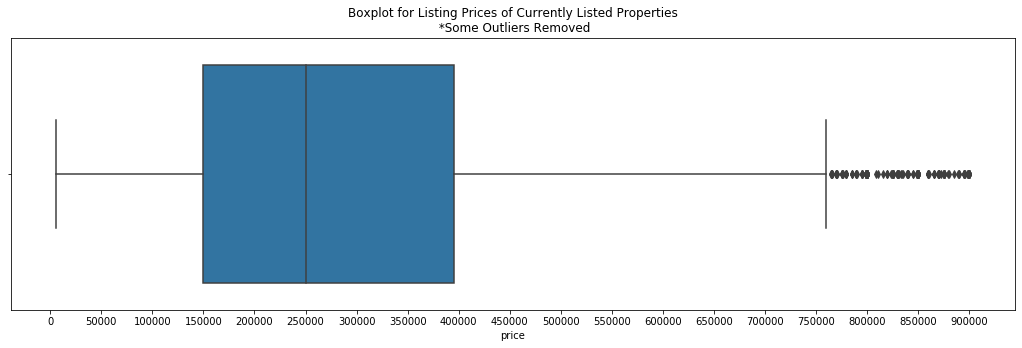

In [382]:
plt.subplots(figsize=(18,5))
curr_prices_plot = sns.boxplot(curr_df2['price'])
curr_prices_plot.set(xticks=np.arange(0, 900001, 50000))
curr_prices_plot.set_title('Boxplot for Listing Prices of Currently Listed Properties\n *Some Outliers Removed')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [363]:
print('Descriptive statistics for the historical data with some outliers removed.')
stats.describe(final_hist2['price'])

Descriptive statistics for the historical data with some outliers removed.


DescribeResult(nobs=2320, minmax=(900, 899900), mean=224190.11422413794, variance=37054673065.41816, skewness=1.1809450478949075, kurtosis=0.8331384196145772)

In [364]:
print('Descriptive statistics for the current data with some outliers removed.')
stats.describe(curr_df2['price'])

Descriptive statistics for the current data with some outliers removed.


DescribeResult(nobs=8984, minmax=(6000, 899999), mean=288463.20102404273, variance=35837855787.81599, skewness=0.8872424310694464, kurtosis=0.4016677938819764)

## Do we have equal variance for the full datasets?

In [352]:
print(stats.bartlett(final_hist['price'], curr_df['price']), '\n')
print(stats.levene(final_hist['price'], curr_df['price']), '\n')
print(stats.fligner(final_hist['price'], curr_df['price'], center='mean'))

BartlettResult(statistic=1181.551070969831, pvalue=6.234360610688021e-259) 

LeveneResult(statistic=22.254141468634682, pvalue=2.41525136944328e-06) 

FlignerResult(statistic=227.9618049165542, pvalue=1.659003770280044e-51)


#### The small p-value in all three tests tells us that we do not have equal variance between the full datasets.

## Do we have equal variance for the datasets with some outliers removed?

In [353]:
print(stats.bartlett(final_hist2['price'], curr_df2['price']), '\n')
print(stats.levene(final_hist2['price'], curr_df2['price']), '\n')
print(stats.fligner(final_hist2['price'], curr_df2['price'], center='mean'))

BartlettResult(statistic=1.0340415120566444, pvalue=0.3092113193400671) 

LeveneResult(statistic=0.09343572298594785, pvalue=0.75985958622035) 

FlignerResult(statistic=0.9103168962954, pvalue=0.3400303507920644)


### All three of the tests for equal varaince have large p-values, which suggests that we do have equal variance for our datasets with some outliers removed.

## Is the mean of the historical data equal to the mean of the current data - for the full datasets?

In [354]:
stats.ttest_ind(final_hist['price'], curr_df['price'], equal_var=False)

Ttest_indResult(statistic=0.009699828541209252, pvalue=0.992261426365225)

### The large p-value tells us that we can accept the null hypothesis that the means are equal. We can conclude that the mean of listing prices before the pandemic is equal to the mean of prices during the pandemic when considering the full datasets.

In [355]:
stats.ttest_ind(final_hist2['price'], curr_df2['price'], equal_var=True)

Ttest_indResult(statistic=-14.52825247868529, pvalue=2.1435395293392626e-47)

### The small p-value tells us that we can reject the null hypothesis that the means are equal. We can conclude that the mean of listing prices before the pandemic is equal to the mean of listing prices during the pandemic when considering the datasets with some outliers removed.

In [356]:
stats.ttest_ind(top5_hist['price'], top5_curr['price'])

Ttest_indResult(statistic=-2.6484333009208254, pvalue=0.008185553625873882)

In [357]:
stats.ttest_ind(bot5_hist['price'], bot5_curr['price'])

Ttest_indResult(statistic=0.30626042781601365, pvalue=0.7596524109248928)